In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline # don't overwrite sklearn's "vanilla" Pipeline
from imblearn.over_sampling import SMOTE # for oversampling the minority class, i.e generating synthetic samples

import matplotlib.pyplot as plt
import seaborn as sns

import os

This is the continuation of the notebook `customer_lead_generator_eda.ipynb`.

__Helper function__

Function to plot the ROC curve, calculate AUC for a base model and the AUC of our model.

In [2]:
def plot_roc(y_test, proba_preds, model_name):

    # create linear line for dummy classifier with 50% random probability of predictions
    base_probs = [0 for _ in range(len(y_test))] # 0 is the majority class, could also sample randomly
    base_auc = roc_auc_score(y_test, base_probs)

    # get auc for ML model
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) # roc curve for the dummy model (3rd output: threshold, not using for plotting)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds) # roc curve for your model

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## 3. Model Development

### Import the processed data

In [3]:
data_folder = 'data'
filename = 'CustomerData_LeadGenerator.csv'

clean_filename = filename.replace('.csv', '_clean.csv')
customer_data_path_clean = os.path.join(data_folder, clean_filename)

clean_reduced_filename = filename.replace('.csv', '_clean_reduced.csv')
customer_data_path_clean_reduced = os.path.join(data_folder, clean_reduced_filename)

df = pd.read_csv(customer_data_path_clean, index_col=0)
df.head()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,...,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_gekauft_gesamt
0,0,0,0,0,0,0,0,0,0,1,...,195228,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1
1,0,0,0,1,1,1,0,0,0,0,...,168291,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1
2,0,0,0,1,0,1,0,0,0,1,...,189787,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1
3,0,1,1,0,0,0,0,0,0,0,...,189634,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,0
4,0,0,0,0,0,1,0,0,0,1,...,207590,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1


In [4]:
df_reduced = pd.read_csv(customer_data_path_clean_reduced, index_col=0)
df_reduced

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,q_Uni by Total Pop,q_2017 Medical Products: Per Capita,b_gekauft_gesamt
0,0,0,0,0,0,0,0,0,0,1,4,36.0,2.1,0.186735,23730.35,2194057,0.147971,326.28,1
1,0,0,0,1,1,1,0,0,0,0,4,20.0,2.1,0.179848,23343.26,1966798,0.142938,320.36,1
2,0,0,0,1,0,1,0,0,0,1,0,0.0,2.1,0.184935,23674.18,2149624,0.149015,325.57,1
3,0,1,1,0,0,0,0,0,0,0,4,20.0,2.1,0.184523,23572.26,2161445,0.143876,324.06,0
4,0,0,0,0,0,1,0,0,0,1,5,33.0,2.1,0.189871,23821.63,2302959,0.145439,327.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,0,0,0,0,0,0,0,0,0,0,0,0.0,2.2,0.203542,23869.52,327760,0.125418,325.57,0
3769,0,0,0,0,0,0,0,0,0,1,0,0.0,2.1,0.184899,23677.97,2150320,0.149148,326.32,0
3770,0,0,0,0,0,0,0,0,0,0,0,0.0,2.1,0.186292,23721.89,2167556,0.149137,326.22,0
3771,0,0,0,0,0,0,0,0,0,1,0,0.0,2.2,0.222034,24711.33,328260,0.116490,342.68,0


### Reduced data and logistic regression
#### Train - test split

In [5]:
target = "b_gekauft_gesamt"
df_reduced_train, df_reduced_test = train_test_split(
    df_reduced, test_size=0.2, random_state=5, stratify=df_reduced[target])
# without stratify=y the class proportions might shift a bit - ensures equal class proportions
df_reduced_train.shape, df_reduced_test.shape

((3018, 19), (755, 19))

In [6]:
X_reduced_train = df_reduced_train.drop(columns=[target])
y_train = df_reduced_train[target]
X_reduced_test = df_reduced_test.drop(columns=[target])
y_test = df_reduced_test[target]
X_reduced_train.shape, X_reduced_test.shape, y_train.shape, y_test.shape

((3018, 18), (755, 18), (3018,), (755,))

In [7]:
# Check how balanced our data is
y_train.value_counts()

b_gekauft_gesamt
0    2972
1      46
Name: count, dtype: int64

In [8]:
y_test.value_counts()

b_gekauft_gesamt
0    744
1     11
Name: count, dtype: int64

#### Logistic Regression model using class weights
* Using class_weight = ‘balanced’, as the dataset is unbalanced
* Using solver = 'lbfgs' because it works for no penalty Logistic Regression

In [9]:
model_logreg = LogisticRegression(
    class_weight="balanced", solver="lbfgs", penalty=None, random_state=42, max_iter=1000
)
model_logreg

LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

In [10]:
model_logreg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': None,
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

* Define Numeric Transformer and Logistic Regression Pipeline
* Since we have only numeric features, we simply use `KNNImputer` for missing values imputation and `StandardScaler` for scaling
* If we would have categorical features, we would need to
  1) separate features by type,
  2) in one `Pipeline`, fill missing values using `SimpleImputer` and transform categorical features into integers using `OneHotEncoder`,
  3) in other `Pipeline`, transform numerical features using `KNNImputer` and `StandardScaler`,
  4) combine the two pipelines into one using `ColumnTransformer` and, finally,
  5) add it as the first step in the final `Pipeline` for modelling.

In [11]:
pipeline_logreg = Pipeline(steps=[
    ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
    ("scaler", StandardScaler().set_output(transform="pandas")),
    ("classifier", model_logreg)
])

pipeline_logreg

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty=None, random_state=42))])

In [12]:
pipeline_logreg.fit(X_reduced_train, y_train)

scores = {}
model_name_reduced = "Logistic Regression with Class Weights (X_reduced)"

pred_logreg_reduced = pipeline_logreg.predict(X_reduced_test)
scores[model_name_reduced] = f1_score(y_test, pred_logreg_reduced) # it is F1 score of the minority class

In [13]:
print(classification_report(y_test, pred_logreg_reduced))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       744
           1       0.04      0.73      0.08        11

    accuracy                           0.76       755
   macro avg       0.52      0.75      0.47       755
weighted avg       0.98      0.76      0.85       755



In [14]:
print(confusion_matrix(y_test, pred_logreg_reduced, labels=[0, 1]))

[[569 175]
 [  3   8]]


Logistic: ROC AUC=0.780


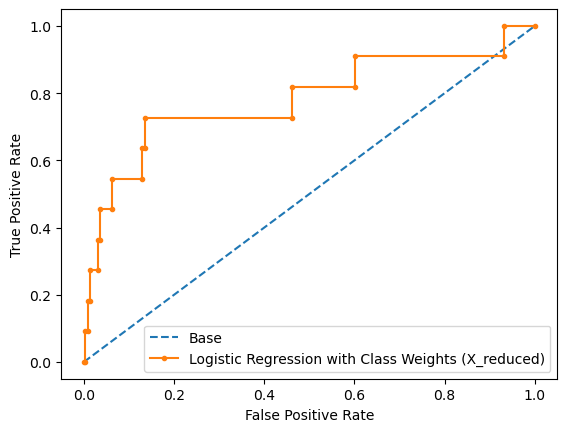

In [15]:
proba_preds_logreg_reduced = pipeline_logreg.predict_proba(X_reduced_test)[:, 1]
plot_roc(y_test, proba_preds_logreg_reduced, model_name=model_name_reduced)

#### Logistic Regression model using SMOTE - Synthetic Over-Sampling

In [16]:
pipeline_smote_logreg = ImbPipeline(steps=[
    ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
    ("scaler", StandardScaler().set_output(transform="pandas")),
    ("smote", SMOTE(random_state=42)), # this step is only in imblearn.pipeline's Pipeline
    ("classifier", model_logreg)
                              ])
pipeline_smote_logreg

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty=None, random_state=42))])

In [17]:
# Checking the upsampling
pipeline_smote_logreg[:3]

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42))])

In [18]:
X_train_res, y_train_res = pipeline_smote_logreg[:3].fit_resample(X_reduced_train, y_train)
y_train_res.value_counts() # now 1 label is as frequent as 0

b_gekauft_gesamt
0    2972
1    2972
Name: count, dtype: int64

In [19]:
y_train.value_counts() # before

b_gekauft_gesamt
0    2972
1      46
Name: count, dtype: int64

In [20]:
pipeline_smote_logreg.fit(X_reduced_train, y_train)

model_name_smote_reduced = "Logistic Regression with SMOTE (X_reduced)"

pred_logreg_smote_reduced = pipeline_smote_logreg.predict(X_reduced_test)
scores[model_name_smote_reduced] = f1_score(y_test, pred_logreg_smote_reduced) # it is F1 score of the minority class

In [21]:
print(classification_report(y_test, pred_logreg_smote_reduced))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       744
           1       0.04      0.73      0.08        11

    accuracy                           0.74       755
   macro avg       0.52      0.73      0.46       755
weighted avg       0.98      0.74      0.84       755



In [22]:
print(confusion_matrix(y_test, pred_logreg_smote_reduced, labels=[0, 1]))

[[550 194]
 [  3   8]]


Logistic: ROC AUC=0.759


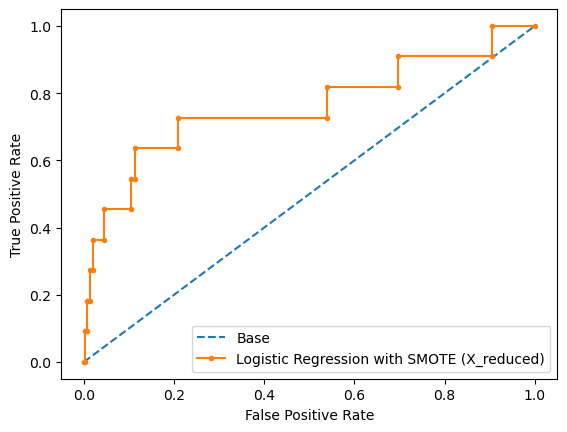

In [23]:
proba_preds_logreg_smote_reduced = pipeline_smote_logreg.predict_proba(X_reduced_test)[:, 1]
plot_roc(y_test, proba_preds_logreg_smote_reduced, model_name=model_name_smote_reduced)

### Full data and logistic regression
#### Train - test split

In [24]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=5, stratify=df[target])
df_train.shape, df_test.shape

((3018, 24), (755, 24))

In [25]:
X_train = df_train.drop(columns=[target])
#y_train = df_train[target] #same as before
X_test = df_test.drop(columns=[target])
#y_test = df_test[target] #same as before
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3018, 23), (755, 23), (3018,), (755,))

#### Logistic Regression model using class weights

In [26]:
pipeline_logreg.fit(X_train, y_train)

model_name = "Logistic Regression with Class Weights (X full)"

pred_logreg = pipeline_logreg.predict(X_test)
scores[model_name] = f1_score(y_test, pred_logreg)

In [27]:
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       744
           1       0.04      0.73      0.08        11

    accuracy                           0.77       755
   macro avg       0.52      0.75      0.47       755
weighted avg       0.98      0.77      0.86       755



In [28]:
print(confusion_matrix(y_test, pred_logreg, labels=[0, 1]))

[[571 173]
 [  3   8]]


Logistic: ROC AUC=0.775


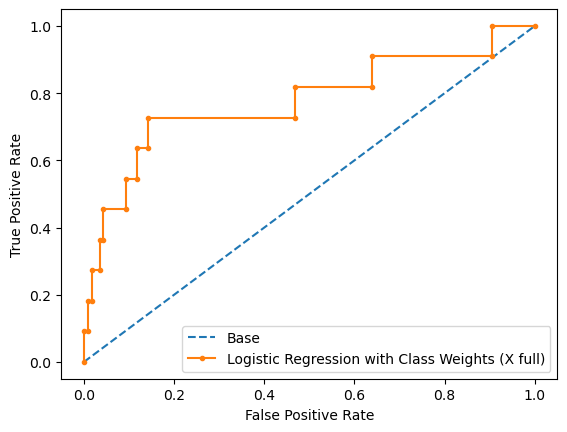

In [29]:
proba_preds_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]
plot_roc(y_test, proba_preds_logreg, model_name=model_name)

### Compare model performance

In [36]:
scores_df

,F1 score
model,


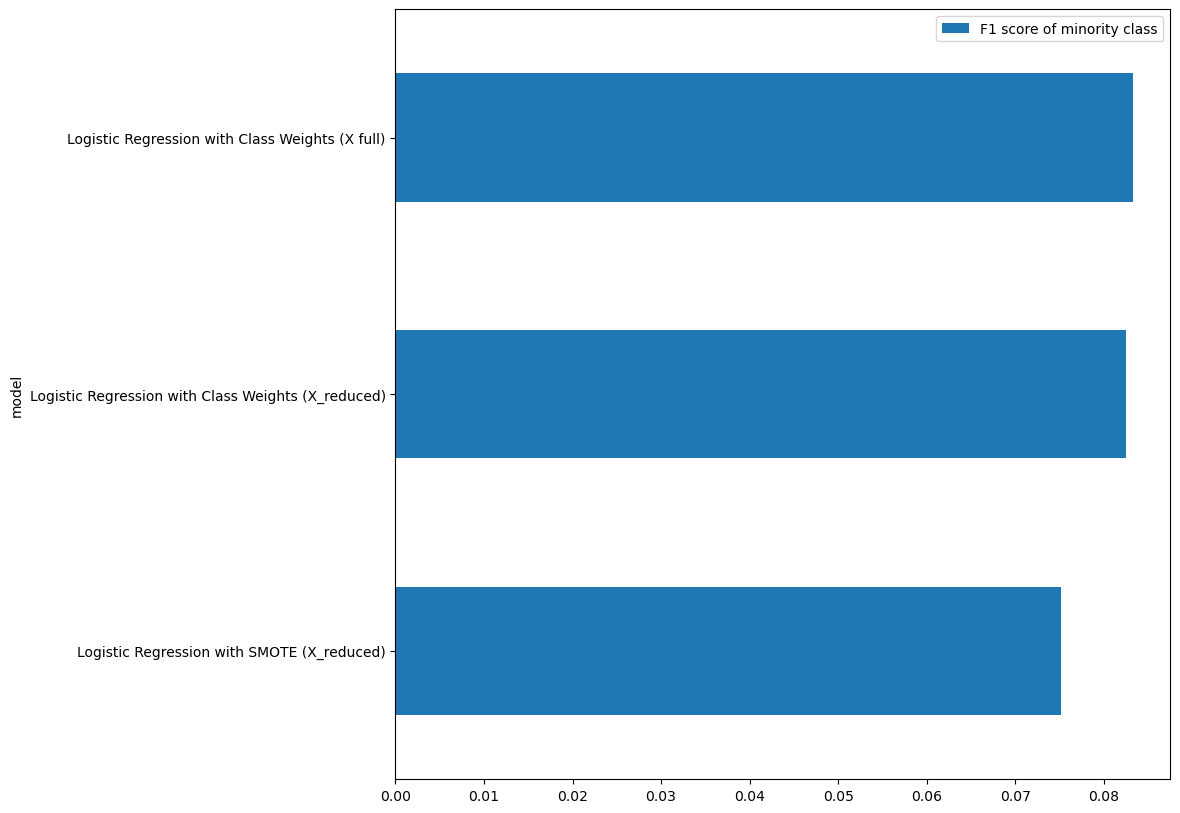

In [40]:
scores_df = pd.DataFrame({
    'model': scores.keys(), 'F1 score of minority class': scores.values()
})
scores_df = scores_df.sort_values('F1 score of minority class', ascending=True).set_index("model")
f, ax = plt.subplots(figsize=(10,10)) 
scores_df.plot(kind="barh", ax=ax);

__Conclusion__
* Logistic regression model using SMOTE performes worse for the majority class and the same for the minority class compared to using class weights.
* Logistic regression model using full data performes comparable to the same model but using reduced data.
* Will not try undersamling because there is already very little data for the minority label (46 samples).
* It's time to try a tree-based model, which is more robust to class inbalance.